# Imports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from numba import jit, prange
import numpy as np

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:71% !important; }</style>"))

# Exploring Data

In [4]:
dataByCountry = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

In [5]:
dataByCountry

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


# Studying Climate data by Country

In [6]:
dataByCountry.isna().sum() / dataByCountry.shape[0]

dt                               0.000000
AverageTemperature               0.056542
AverageTemperatureUncertainty    0.055263
Country                          0.000000
dtype: float64

In [7]:
dataByCountry = dataByCountry.dropna()
print(dataByCountry.isna().sum())
dataByCountry.shape

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64


(544811, 4)

In [8]:
dataByCountry.dt = pd.to_datetime(dataByCountry.dt)
dataByCountry.set_index('dt', inplace=True)

In [9]:
#Countries
# for i in dataByCountry.Country.value_counts().index : print(i)

# Adding Missing Countries

In [10]:
def fixCountryData(rawData, countryName) :
    fixedData = pd.DataFrame(columns=['AverageTemperature'])
    for i in range(rawData.shape[0]):
        for month in list(rawData.columns)[1:] :
            index = f"{rawData['Year'][i]}-{month}-01"
            fixedData = fixedData.append(pd.DataFrame([ rawData[month][i] ], columns=['AverageTemperature'], index=[index]))
    fixedData['AverageTemperatureUncertainty'] = 0
    fixedData['Country'] = countryName
    fixedData.index = pd.to_datetime(fixedData.index)
    
    return fixedData

In [11]:
missingCountriesISO3 = ['BMU','BRN','COK','FLK','MHL','NFK','NRU','SSD','TUV','VUT','WLF']
missingCountriesNames = ["Bermuda", "Brunei", "Cook Islands", "Falkland Islands (Malvinas)", "Marshall Islands",
                         "Norfolk Island", "Nauru", "South Sudan", "Tuvalu", "Vanuatu", "Wallis and Futuna"]

In [12]:
# for i in range(len(missingCountriesISO3)) :
#     missingCoutryData = pd.read_csv(f'./Missing Countries/Monthly_cru_1901-2021_{missingCountriesISO3[i]}.csv')
#     newCountryData = fixCountryData(missingCoutryData,missingCountriesNames[i])
#     dataByCountry = dataByCountry.append(newCountryData)
# dataByCountry.index.name = 'dt'

### Adding Kosovo

In [13]:
def resampledData(data, timeframe) :
    return data.resample(timeframe, origin='start').agg({'AverageTemperature': 'mean','AverageTemperatureUncertainty': 'mean'})

In [14]:
# kosovoData = pd.read_json('./Missing Countries/kosovoDailyTemperature.json')
# kosovoDailyData = pd.DataFrame()
# kosovoDailyData['dt'] = pd.Series(kosovoData.daily.time)
# kosovoDailyData['AverageTemperature'] = pd.Series( (np.array(kosovoData.daily.temperature_2m_max)+np.array(kosovoData.daily.temperature_2m_min)) / 2 )
# kosovoDailyData['AverageTemperatureUncertainty'] = 0
# kosovoDailyData.dt = pd.to_datetime(kosovoDailyData.dt)
# kosovoDailyData.set_index('dt', inplace=True)

# kosovoMonthlyData = resampledData(kosovoDailyData, '1M')
# kosovoMonthlyData['Country'] = 'Kosovo'
# dataByCountry = dataByCountry.append(kosovoMonthlyData)

# dataByCountry.to_csv("AllGlobalLandTemperaturesByCountry.csv",index=True)

In [15]:
dataByCountry = pd.read_csv("AllGlobalLandTemperaturesByCountry.csv")
dataByCountry.dt = pd.to_datetime(dataByCountry.dt)
dataByCountry.set_index('dt', inplace=True)

# Compare Temperature Chart

In [16]:
def compareCountries(data, countries, timeframe, plot): 
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(30,10))
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    for country in countries :  
        dataForCountry = resampledData( dataByCountry[dataByCountry.Country==country], timeframe )
        plot(dataForCountry.index,dataForCountry.AverageTemperature)
    plt.legend(countries)

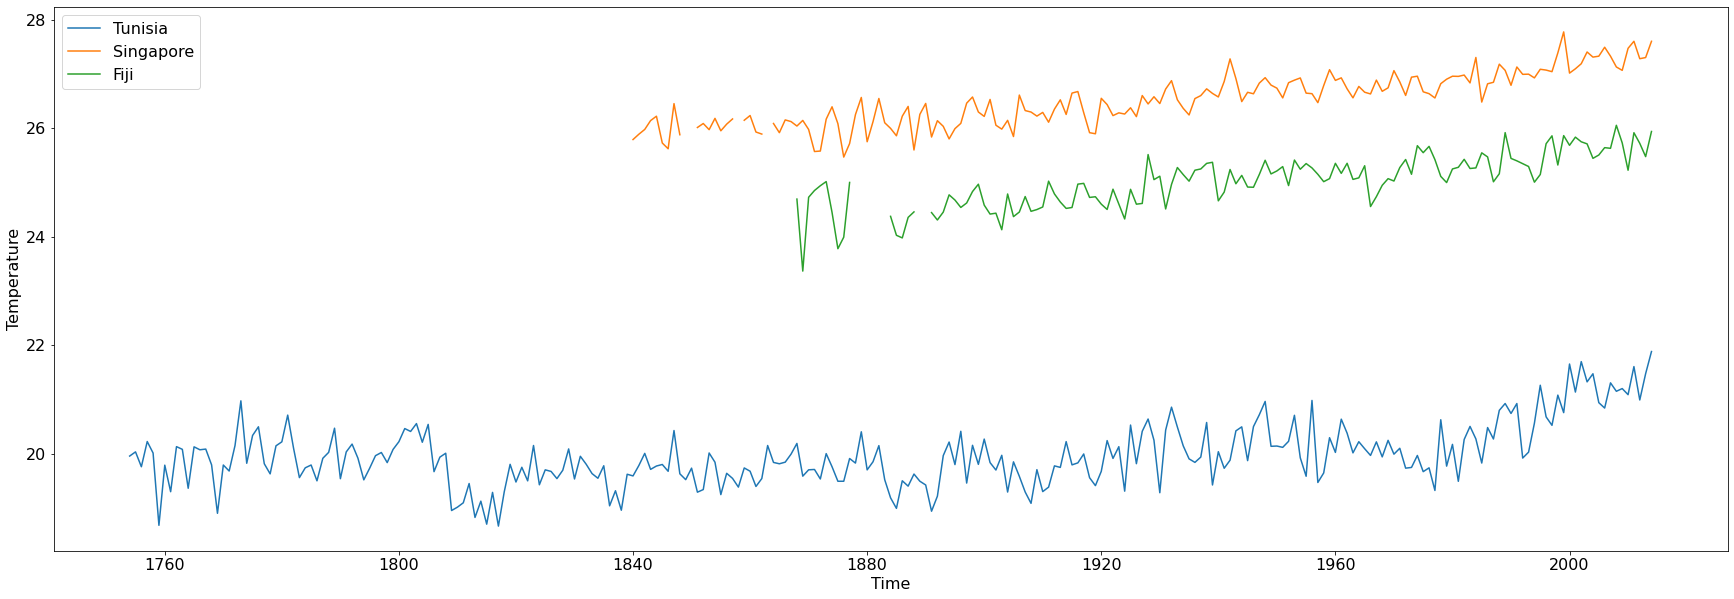

In [17]:
compareCountries(dataByCountry, ['Tunisia','Singapore','Fiji'], '1Y',plt.plot)

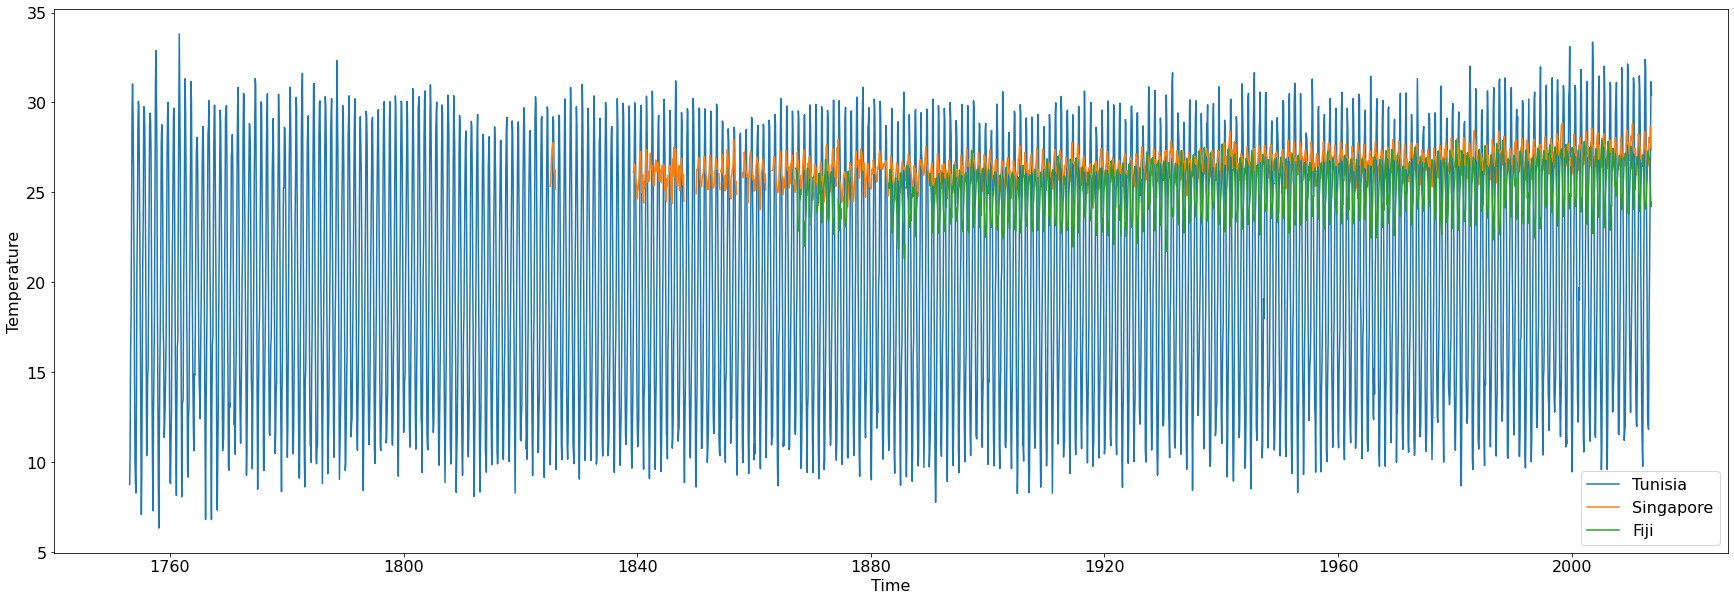

In [18]:
compareCountries(dataByCountry, ['Tunisia','Singapore','Fiji'], '1M',plt.plot)

# Regression

In [19]:
countriesList = pd.DataFrame(columns=['Country'],data=dataByCountry.Country.value_counts().index)
countriesList['Country_ID'] = countriesList.index
countryData = dataByCountry.join(countriesList.set_index('Country'), on='Country')
countryData = countryData[countryData.Country=='Tunisia']
countryData = countryData[countryData.index >= '1800']
countryData

,AverageTemperature,AverageTemperatureUncertainty,Country,Country_ID
dt,,,,
1800-01-01,12.285,1.628,Tunisia,50
1800-02-01,14.460,3.653,Tunisia,50
1800-03-01,14.919,1.759,Tunisia,50
1800-04-01,20.212,1.751,Tunisia,50
1800-05-01,23.040,1.550,Tunisia,50
...,...,...,...,...
2013-04-01,20.383,0.746,Tunisia,50
2013-05-01,24.268,0.336,Tunisia,50
2013-06-01,27.488,0.947,Tunisia,50


In [20]:
target = 'AverageTemperature'
feat = ['AverageTemperature', 'AverageTemperatureUncertainty']
features = pd.DataFrame(data=countryData, columns=feat)
features

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1800-01-01,12.285,1.628
1800-02-01,14.460,3.653
1800-03-01,14.919,1.759
1800-04-01,20.212,1.751
1800-05-01,23.040,1.550
...,...,...
2013-04-01,20.383,0.746
2013-05-01,24.268,0.336
2013-06-01,27.488,0.947


### Feature Engineering

In [21]:
scaler = StandardScaler().fit(features)
# features = pd.DataFrame(data=scaler.transform(features), columns=feat, index=countryData.index)
features['Month'] = features.index.month
features['Day'] =  features.index.dayofyear
# features['Season'] = features.index.month // 4 + 1 ;  features[features.Season == 4] = 1
features

,AverageTemperature,AverageTemperatureUncertainty,Month,Day
dt,,,,
1800-01-01,12.285,1.628,1,1
1800-02-01,14.460,3.653,2,32
1800-03-01,14.919,1.759,3,60
1800-04-01,20.212,1.751,4,91
1800-05-01,23.040,1.550,5,121
...,...,...,...,...
2013-04-01,20.383,0.746,4,91
2013-05-01,24.268,0.336,5,121
2013-06-01,27.488,0.947,6,152


In [22]:
newfeatures = features.head(countryData.shape[0]-1)
result = countryData[target].tail(countryData.shape[0]-1)
result = result

newfeatures.index = newfeatures.index + pd.DateOffset(months=1)

In [23]:
newfeatures

,AverageTemperature,AverageTemperatureUncertainty,Month,Day
dt,,,,
1800-02-01,12.285,1.628,1,1
1800-03-01,14.460,3.653,2,32
1800-04-01,14.919,1.759,3,60
1800-05-01,20.212,1.751,4,91
1800-06-01,23.040,1.550,5,121
...,...,...,...,...
2013-04-01,17.582,0.551,3,60
2013-05-01,20.383,0.746,4,91
2013-06-01,24.268,0.336,5,121


###  Finding Best Random State

In [24]:
@jit(parallel=True, forceobj=True)
def bestRandomState(a: int, b: int, features, target, intercept: bool = True):
    valuesDict = {'bic': [], 'mse': [], 'rsq': [], 'avgRsq': []}
    bic, mse, rsq, avgRsq = [], [], [], []
    for i in range(a, b):
        xTrain, xTest, yTrain, yTest = train_test_split(features, target, test_size=.2, random_state=i)
        regr = LinearRegression(fit_intercept=intercept).fit(xTrain, yTrain)
        xAndConst = sm.add_constant(xTrain)
        if not intercept:
            xAndConst = xAndConst.drop(['const'], axis=1)
        model = sm.OLS(yTrain, xAndConst)
        results = model.fit()
        bic.append(results.bic)
        rsq.append(regr.score(xTest, yTest))
        mse.append(results.mse_resid)
        avgScore = (regr.score(xTest, yTest) + regr.score(xTrain, yTrain)) / 2
        avgRsq.append(avgScore)
    valuesDict['bic'] = [min(bic), bic.index(min(bic))]
    valuesDict['mse'] = [min(mse), mse.index(min(mse))]
    valuesDict['rsq'] = [max(rsq), rsq.index(max(rsq))]
    valuesDict['avgRsq'] = [max(avgRsq), avgRsq.index(max(avgRsq))]

    return valuesDict

In [25]:
rnd = bestRandomState(0,3000,newfeatures, result, True)
rnd

{'bic': [9085.937572729243, 2026],
 'mse': [4.845888408104919, 2026],
 'rsq': [0.911887843341157, 1293],
 'avgRsq': [0.9004715462683448, 1299]}

In [26]:
# rnd['rsq']

### Linear Regression

In [27]:
xTrain, xTest, yTrain, yTest = train_test_split(newfeatures, result, test_size=.2, random_state=rnd['rsq'][1])
# regr =  RandomForestRegressor().fit(xTrain,yTrain)
regr =  LinearRegression().fit(xTrain,yTrain)
print('R² Training Data: ', regr.score(xTrain,yTrain))
print('R² Test Data: ', regr.score(xTest,yTest))

R² Training Data:  0.8889501950231053
R² Test Data:  0.911887843341157


In [28]:
xAndConst = sm.add_constant(xTrain)
model = sm.OLS(yTrain, xAndConst)
results = model.fit()
pandaPvalues = pd.DataFrame({'coef':results.params, 'p-values':round(results.pvalues,4)})

print('Bic :', results.bic)
print('RMSE :', np.sqrt(results.mse_resid))
print('Rsquared : ', results.rsquared)
pandaPvalues.sort_values(by='p-values')

Bic : 9224.111767428
RMSE : 2.2767894629789405
Rsquared :  0.8889501950231049


,coef,p-values
const,-42.715855,0.000
AverageTemperature,0.879262,0.000
Month,49.720601,0.000
Day,-1.657877,0.000
AverageTemperatureUncertainty,-0.019238,0.731


# Globe Visualization

### Readying data for Dash and ThreeJs apps 

In [29]:
codes = pd.read_csv('countries_codes_and_coordinates.csv')
data = pd.read_csv("AllGlobalLandTemperaturesByCountry.csv")
data = data.dropna()
data.dt = pd.to_datetime(data.dt)
data

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384000,2.294,Åland
1,1744-04-01,1.530000,4.680,Åland
2,1744-05-01,6.702000,1.789,Åland
3,1744-06-01,11.609000,1.577,Åland
4,1744-07-01,15.342000,1.410,Åland
...,...,...,...,...
561175,2012-09-30,19.590000,0.000,Kosovo
561176,2012-10-31,14.214516,0.000,Kosovo
561177,2012-11-30,8.431667,0.000,Kosovo
561178,2012-12-31,-0.112903,0.000,Kosovo


In [30]:
countriesAndCodes = data.join(codes.set_index('Country'), on='Country')
countriesAndCodes

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,1743-11-01,4.384000,2.294,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
1,1744-04-01,1.530000,4.680,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
2,1744-05-01,6.702000,1.789,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
3,1744-06-01,11.609000,1.577,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
4,1744-07-01,15.342000,1.410,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
...,...,...,...,...,...,...,...,...,...
561175,2012-09-30,19.590000,0.000,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
561176,2012-10-31,14.214516,0.000,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
561177,2012-11-30,8.431667,0.000,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
561178,2012-12-31,-0.112903,0.000,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""


In [31]:
countriesAndCodes[countriesAndCodes['Alpha-3 code'] == ' "XXK"']

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
560783,1980-01-31,-4.000000,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
560784,1980-02-29,1.336207,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
560785,1980-03-31,4.737097,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
560786,1980-04-30,7.396667,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
560787,1980-05-31,11.764516,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
...,...,...,...,...,...,...,...,...,...
561175,2012-09-30,19.590000,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
561176,2012-10-31,14.214516,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
561177,2012-11-30,8.431667,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
561178,2012-12-31,-0.112903,0.0,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""


In [32]:
test = pd.DataFrame(data = countriesAndCodes, columns=['Country','Alpha-3 code']).groupby(['Country']).first().isna()
l=list(test[test['Alpha-3 code'] == True].index)
l

['Africa',
 'Asia',
 'Denmark (Europe)',
 'Europe',
 'Falkland Islands (Islas Malvinas)',
 'France (Europe)',
 'Gaza Strip',
 'Kingman Reef',
 'Netherlands',
 'North America',
 'Oceania',
 'Palmyra Atoll',
 'South America',
 'United Kingdom (Europe)']

In [33]:
newData = countriesAndCodes.copy(deep=True)
for i in l :
    newData.drop(newData[newData.Country == i].index, axis=0, inplace=True)
newData.set_index('dt', inplace=True)
newData

,AverageTemperature,AverageTemperatureUncertainty,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
dt,,,,,,,,
1743-11-01,4.384000,2.294,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
1744-04-01,1.530000,4.680,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
1744-05-01,6.702000,1.789,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
1744-06-01,11.609000,1.577,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
1744-07-01,15.342000,1.410,Åland,"""AX""","""ALA""","""248""","""60.116667""","""19.9"""
...,...,...,...,...,...,...,...,...
2012-09-30,19.590000,0.000,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
2012-10-31,14.214516,0.000,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""
2012-11-30,8.431667,0.000,Kosovo,"""XK""","""XXK""","""383""","""42.6""","""20.9"""


In [34]:
def resampledBigData(data, timeframe) :
    return data.resample(timeframe, origin='start').agg({'AverageTemperature': 'mean','AverageTemperatureUncertainty': 'mean',
                                                        'Country': 'first', 'Alpha-2 code': 'first', 'Alpha-3 code': 'first',
                                                        'Numeric code': 'first', 'Latitude (average)': 'first', 'Longitude (average)': 'first'})

In [35]:
yearData = pd.DataFrame()

In [36]:
for country in newData.Country.value_counts().index :
    yearData = pd.concat([yearData, resampledBigData(newData[newData.Country == country],'1Y')])


In [37]:
yearData.dropna(inplace = True)
yearData['Year'] = yearData.index.year
yearData['Alpha-3 code'] = yearData['Alpha-3 code'].str[2:-1]
yearData['Alpha-2 code'] = yearData['Alpha-2 code'].str[2:-1]

In [38]:
# [i for i in yearData['Alpha-3 code'].value_counts().index]

In [39]:
# yearData.to_csv("YearlyTemperaturesByCountryWithAlpha3.csv",index=True)

In [40]:
geoData = gpd.read_file('../files/map-medium-res.geo.json')
geoData.loc[geoData.sov_a3 == 'SOL', 'iso_a3_eh'] = 'SOM'
geoData.loc[geoData.sov_a3 == 'CYN', 'iso_a3_eh'] = 'CYP'
geoData.loc[geoData.sov_a3 == 'KAS', 'iso_a3_eh'] = 'IND'
geoData.loc[geoData.sov_a3 == 'KOS', 'iso_a3_eh'] = 'XXK'

In [41]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.expand_frame_repr', False)
geoData[geoData.adm0_a3 == 'FRA']

,featurecla,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,tlc,admin,adm0_a3,geou_dif,geounit,gu_a3,su_dif,subunit,su_a3,brk_diff,name,name_long,brk_a3,brk_name,brk_group,abbrev,postal,formal_en,formal_fr,name_ciawf,note_adm0,note_brk,name_sort,name_alt,mapcolor7,mapcolor8,mapcolor9,mapcolor13,pop_est,pop_rank,pop_year,gdp_md,gdp_year,economy,income_grp,fips_10,iso_a2,iso_a2_eh,iso_a3,iso_a3_eh,iso_n3,iso_n3_eh,un_a3,wb_a2,wb_a3,woe_id,woe_id_eh,woe_note,adm0_iso,adm0_diff,adm0_tlc,adm0_a3_us,adm0_a3_fr,adm0_a3_ru,adm0_a3_es,adm0_a3_cn,adm0_a3_tw,adm0_a3_in,adm0_a3_np,adm0_a3_pk,adm0_a3_de,adm0_a3_gb,adm0_a3_br,adm0_a3_il,adm0_a3_ps,adm0_a3_sa,adm0_a3_eg,adm0_a3_ma,adm0_a3_pt,adm0_a3_ar,adm0_a3_jp,adm0_a3_ko,adm0_a3_vn,adm0_a3_tr,adm0_a3_id,adm0_a3_pl,adm0_a3_gr,adm0_a3_it,adm0_a3_nl,adm0_a3_se,adm0_a3_bd,adm0_a3_ua,adm0_a3_un,adm0_a3_wb,continent,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,min_zoom,min_label,max_label,label_x,label_y,ne_id,wikidataid,name_ar,name_bn,name_de,name_en,name_es,name_fa,name_fr,name_el,name_he,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_uk,name_ur,name_vi,name_zh,name_zht,fclass_iso,tlc_diff,fclass_tlc,fclass_us,fclass_fr,fclass_ru,fclass_es,fclass_cn,fclass_tw,fclass_in,fclass_np,fclass_pk,fclass_de,fclass_gb,fclass_br,fclass_il,fclass_ps,fclass_sa,fclass_eg,fclass_ma,fclass_pt,fclass_ar,fclass_jp,fclass_ko,fclass_vn,fclass_tr,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,filename,geometry
158,Admin-0 country,1,2,France,FR1,1,2,Country,1,France,FRA,0,France,FRA,0,France,FRA,0,France,France,FRA,France,NaN,Fr.,F,French Republic,NaN,France,NaN,NaN,France,NaN,7,5,9,11,67059887.0,16,2019,2715518,2019,1. Developed region: G7,1. High income: OECD,FR,-99,FR,-99,FRA,-99,250,250,FR,FRA,-90,23424819,Includes only Metropolitan France (including C...,FRA,NaN,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,-99,-99,Europe,Europe,Western Europe,Europe & Central Asia,6,6,3,-99,1,0.0,1.7,6.7,2.552275,46.696113,1159320637,Q142,فرنسا,ফ্রান্স,Frankreich,France,Francia,فرانسه,France,Γαλλία,צרפת,फ़्रान्स,Franciaország,Prancis,Francia,フランス,프랑스,Frankrijk,Francja,França,Франция,Frankrike,Fransa,Франція,فرانس,Pháp,法国,法國,Admin-0 country,NaN,Admin-0 country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRA.geojson,"MULTIPOLYGON (((9.48037 42.80542, 9.45420 42.6..."


In [42]:
# [i for i in geoData.columns]

In [43]:
geoYearData = geoData.join(yearData.set_index('Alpha-3 code'), on='iso_a3_eh')

In [44]:
geoClimateData = geoYearData[geoYearData.Year >= 1980]

In [45]:
geoClimateData1 = geoClimateData[geoClimateData.Year <= 1996]
geoClimateData2 = geoClimateData[geoClimateData.Year > 1996]

In [46]:
# geoClimateData1.to_file('../files/geoClimateData1.geojson', driver="GeoJSON")
# geoClimateData2.to_file('../files/geoClimateData2.geojson', driver="GeoJSON")

In [47]:
set(geoData.iso_a3_eh) - set(geoClimateData.iso_a3_eh)

{'PCN', 'VAT'}